# Putting it all together: SciKit-Learn inference pipeline

In [1]:
import pickle
from pathlib import Path

from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import KNNImputer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder

import functions.plots as plotting

## 1. Load assets

In [2]:
with open(Path('../data/processed/hyperparameters.pkl'), 'rb' ) as input_file:
    hyperparameters = pickle.load(input_file)
    
with open('../data/processed/train.pkl', 'rb') as input_file:
    train_df = pickle.load(input_file)

with open('../data/processed/test.pkl', 'rb') as input_file:
    test_df = pickle.load(input_file)

In [3]:
train_df.drop(['Heart_Rate', 'User_ID', 'Body_Temp'], inplace=True, axis=1)
train_df.head()

,Calories,Gender,Age,Height,Weight,Duration
9839,17.0,0.0,37,179.0,77.0,7.0
9680,167.0,0.0,23,195.0,87.0,26.0
7093,40.0,0.0,33,181.0,77.0,12.0
11293,34.0,1.0,66,156.0,54.0,9.0
820,23.0,1.0,32,144.0,49.0,5.0


In [4]:
test_df.drop(['Heart_Rate', 'User_ID', 'Body_Temp'], inplace=True, axis=1)
test_df.head()

,Calories,Gender,Age,Height,Weight,Duration
11499,173.0,1.0,45,154.0,52.0,26.0
6475,189.0,0.0,21,187.0,90.0,29.0
13167,53.0,0.0,58,176.0,77.0,11.0
862,161.0,0.0,35,182.0,89.0,24.0
5970,226.0,1.0,67,171.0,67.0,29.0


## 2. Define a column transformer that encodes the categorical features

See SciKit-Learn [`ColumnTransformer()`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html) documentation.

In [5]:
calorie_preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), ['Gender'])
    ],
    remainder='passthrough',
    force_int_remainder_cols=False
)

time_preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), ['Gender'])
    ],
    remainder='passthrough',
    force_int_remainder_cols=False
)

## 3. Define a pipeline that takes raw input and does prediction

See SciKit-Learn [`Pipeline()`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) documentation.

The pipeline will have three steps:

1. **Feature encoder** - (column transformer from section 1, above) - use the strategy you devised in the data preparation notebook.
2. **Imputer** - to fill in any features the user dident know/specify - use the strategy you came up with in the user input imputation notebook.
3. **Regressor** - use the optimized hyperparameters from the model building notebook.

Make TWO pipelines, one for the time model and one for the calories model, and store them in a dict.

In [6]:
pipelines={
    'calorie_model_pipeline' : Pipeline([
        ('preprocessor', calorie_preprocessor),
        ('imputer', KNNImputer(n_neighbors=3, weights='distance')),
        ('model', GradientBoostingRegressor(**hyperparameters))
    ]),

    'time_model_pipeline' : Pipeline([
        ('preprocessor', time_preprocessor),
        ('imputer', KNNImputer(n_neighbors=3, weights='distance')),
        ('model', GradientBoostingRegressor(**hyperparameters))
    ])
}

## 4. Train the pipelines

In [7]:
pipelines['calorie_model_pipeline'].fit(train_df.drop(columns=['Calories']), train_df['Calories'])

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['Gender'])])),
                ('imputer', KNNImputer(n_neighbors=3, weights='distance')),
                ('model',
                 GradientBoostingRegressor(ccp_alpha=0.001, max_depth=4,
                                           max_features=0.5,
                                           min_weight_fraction_leaf=0.001,
                                           n_estimators=300))])

In [8]:
pipelines['time_model_pipeline'].fit(train_df.drop(columns=['Duration']), train_df['Duration'])

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['Gender'])])),
                ('imputer', KNNImputer(n_neighbors=3, weights='distance')),
                ('model',
                 GradientBoostingRegressor(ccp_alpha=0.001, max_depth=4,
                                           max_features=0.5,
                                           min_weight_fraction_leaf=0.001,
                                           n_estimators=300))])

## 5. Evaluate the pipelines

In [9]:
r_sq=pipelines['calorie_model_pipeline'].score(test_df.drop(columns=['Calories']), test_df['Calories'])
print(f'Calorie model R-squared: {r_sq:.4f}')


r_sq=pipelines['time_model_pipeline'].score(test_df.drop(columns=['Duration']), test_df['Duration'])
print(f'Time model R-squared: {r_sq:.4f}')

Calorie model R-squared: 0.9641
Time model R-squared: 0.9742


Calorie Model R-squared: 0.9641


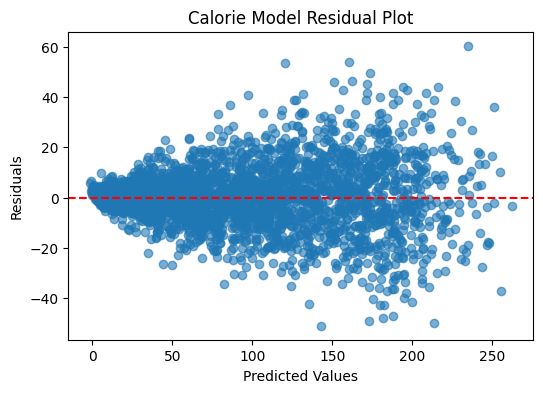

Time Model R-squared: 0.9742


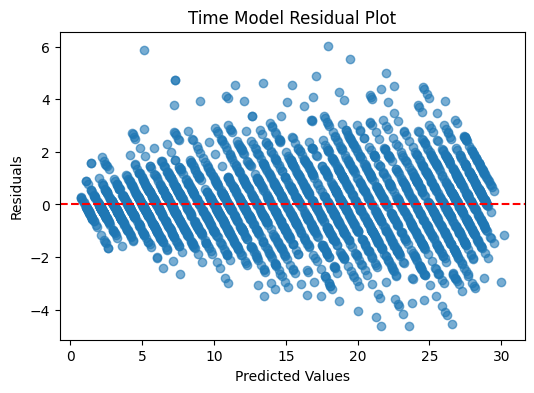

In [10]:
# Evaluate both models
calorie_r_sq = plotting.evaluate_model(pipelines['calorie_model_pipeline'], test_df.drop(columns=['Calories']), test_df['Calories'], "Calorie Model")
time_r_sq = plotting.evaluate_model(pipelines['time_model_pipeline'], test_df.drop(columns=['Duration']), test_df['Duration'], "Time Model")

## 5. Save pipeline for deployment

In [11]:
Path('../models').mkdir(exist_ok=True)

with open('../models/pipelines.pkl', 'wb') as output_file:
    pickle.dump(pipelines, output_file)